# Statistics and Data Analysis - HW4
## Differential Gene Expression in Acute Myocardial Infraction

In this exercise, we will perform guided analysis, comparing expression profiles of circulating endothelial cells (CECs) in patients with acute myocardial infraction to CECs in healthy controls. A comparison of two sample classes.

<b>The fixed CSV file can be found in this link: https://drive.google.com/file/d/1H7WA0TqaLXKDemmr0JQYKOm6LR9NW8SO/view?usp=sharing \
Please use this file when running the program.</b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats

import statsmodels
import statsmodels.stats.multitest as multitest

#### Relevant Versions

In [2]:
print('seaborn version: 0.11.1,', sns.__version__ == '0.11.1')
print('scipy version: 1.6.0,', scipy.__version__ == '1.6.0')
print('statsmodels version: 0.11.0,', statsmodels.__version__ == '0.11.0')

seaborn version: 0.11.1, True
scipy version: 1.6.0, True
statsmodels version: 0.11.0, True


### a. High level description of the data and some pre-processing

#### In this section, you can follow the high-level description of the data, such as:
* The number of profiled genes.
* The total number of samples (patients).
* The number of samples per class (H – Healthy, M - Myocardial Infraction).

#### Pre-processing step: 
* Handling with missing values in the data, by removing the entire row (gene).

#### Visualization:
* Drawing histograms for comparing expression levels of random genes on both classes H and M. 

In [3]:
# import the data set
dataset = pd.read_csv('AMI_GSE66360_series_matrix.csv', low_memory=False)

# remove the first row which is the id of the patients
dataset.drop(0, inplace=True)

# present a sample from the data
dataset.head()

,Class,H,H.1,H.2,H.3,H.4,H.5,H.6,H.7,H.8,...,M.39,M.40,M.41,M.42,M.43,M.44,M.45,M.46,M.47,M.48
1,1007_s_at,5.866377893,4.948736331,5.148384393,5.064418945,5.017832878,5.116153518,5.431328058,5.235270857,5.773528455,...,5.419481538,5.057716465,5.996493392,5.343132759,5.558892254,6.472517225,5.678815851,5.653286378,6.013841046,5.465333944
2,1053_at,8.22579012,7.525865369,7.764636529,7.198461482,7.831450258,7.203591859,7.694550756,7.760259212,8.279814404,...,7.226347747,7.105537863,5.354105386,8.271499725,5.96334574,8.261421952,6.925752665,7.918424183,7.442701377,9.225221352
3,117_at,6.17973231,6.628137025,5.859151477,5.974135101,6.793079158,6.43522914,6.320546126,6.48359047,6.387779205,...,6.789500767,7.441939912,7.026928573,6.003972814,7.474325713,6.367759272,6.835755831,7.577034915,7.147417202,6.48112813
4,121_at,6.179477974,6.58288903,6.602134766,6.545904723,5.911542321,6.28542026,6.562315839,6.345887555,6.27280582,...,6.513436777,6.317522639,7.413453376,6.809103167,5.949091368,6.440978114,6.955883278,6.499215058,6.587065112,6.897590966
5,1255_g_at,2.792047952,2.69571445,2.580181122,2.712123845,2.723686912,2.70668403,2.674746672,2.635149735,2.696649177,...,2.924657514,2.714103313,3.635944854,2.710943641,2.979380765,3.73013912,2.914867562,3.013901455,2.729319786,3.151449425


In [4]:
# dataset's shape
row_size, col_size = dataset.shape[0], dataset.shape[1] - 1
print('\n---- Samples ----')
print(f'Number of genes: {row_size}')
print(f'Number of patients: {col_size}')

# number of samples in each class
columns_names = dataset.columns
healthy_size = np.sum([1 if i.startswith('H') else 0 for i in columns_names])
print('\n---- Classes ----')
print(f'Samples size for the Healthy class: {healthy_size}')
print(f'Samples size for the Myocardial Infraction class: {col_size - healthy_size}')


---- Samples ----
Number of genes: 54675
Number of patients: 99

---- Classes ----
Samples size for the Healthy class: 50
Samples size for the Myocardial Infraction class: 49


In [5]:
# remove missing values
dataset = dataset.dropna(how='any', axis=0)
row_size, col_size = dataset.shape[:2]
print('\n---- Missing Values Results ----')
print(f'Number of updated rows: {row_size}\n')
assert dataset.isnull().values.any() == False


---- Missing Values Results ----
Number of updated rows: 54628



In [6]:
######################
## helper functions ##
######################

def plot_hist(samples_genes_20, gene, ax):
    ax.set_title(gene, fontsize=20)
    ax.set_xlabel('Expression Level', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    samples_genes_20['Class'] = samples_genes_20['Class'].replace({0: 'H', 1: 'M'})
    sns.histplot(data=samples_genes_20, x=gene, hue='Class', multiple='dodge', shrink=.8, ax=ax)
    

def refactor(df):
    df = df.T

    # change the first row to be the columns names
    new_columns_names = df.iloc[0]
    df = df[1:]
    df.columns = new_columns_names

    # adjust the 'Class' column name
    df = df.reset_index()
    df = df.rename(columns={'index': 'Class'}, inplace=False)
    df = df.rename_axis(None, axis=1)

    # convert from classes string to binary representation
    df['Class'] = df['Class'].apply(lambda x: 0 if x.startswith('H') else 1)

    # data types conversion
    df = df.astype(float)
    df['Class'] = df['Class'].astype(int)

    # shift the 'Class' column to the end of the matrix
    cols = list(df.columns)
    cols = np.hstack([cols[1:], cols[0]])

    return df[cols]

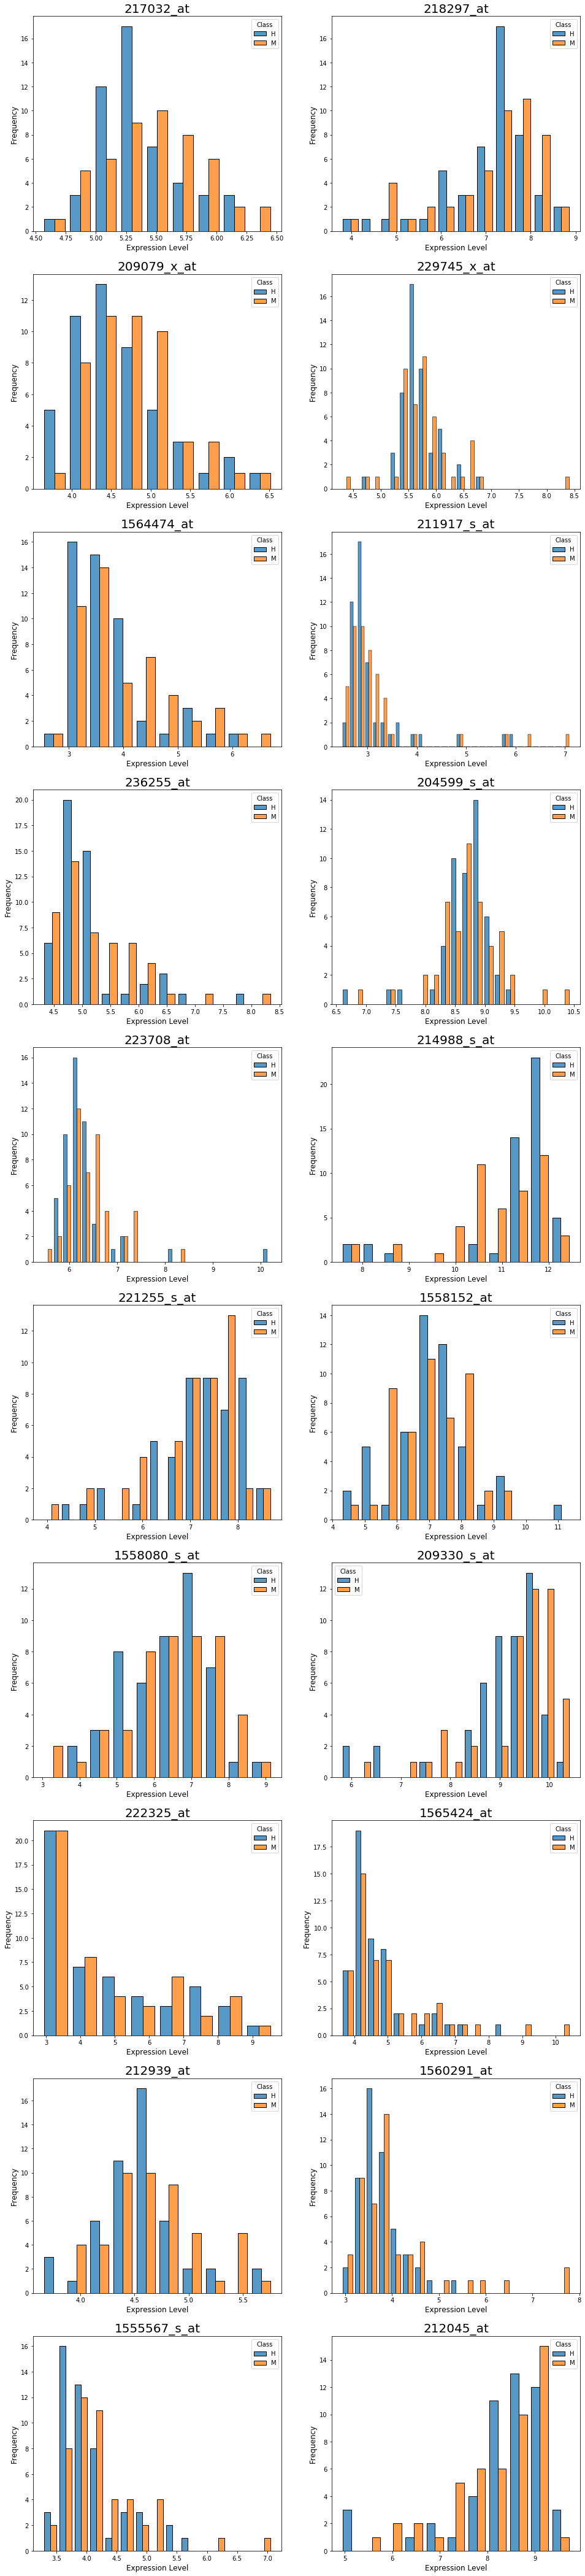

In [7]:
# visualization
plt.rcParams['figure.figsize'] = (16.0, 76.0)

samples_index = np.random.choice(np.arange(row_size), size=20)
samples_genes_20 = refactor(dataset.loc[samples_index])

f, axis = plt.subplots(10, 2)
for gene, ax in zip(samples_genes_20.columns, axis.flatten()):
    plot_hist(samples_genes_20, gene, ax)
    
plt.show()

### b. WRS for differential expression (DE)

In this section, we will consider one sample of a gene, denote as g. \
We will assume that:
* All the observations from both groups are independent of each other.
* Under the null hypothesis ($H_0$), the distributions of both populations are equal. In our case, there is no Differential Expression in the samples M verses H inside g.
* The alternative hypothesis ($H_A$) is that the distributions are not equal. In our case, there is a Differential Expression in the samples M verses H inside g.

Under the null model, I performed a Wilcoxon Rank Sum Test (WRS), to compare those two samples H and M in g (for samples labeled M), using the computations below:
* N = the total size of the samples.
* B = the total size of labeled M.
* T = the sum of ranks.

If the number of observations is large enough, a normal approximation can be used with:
* $\mu_T$ (the expected sum of ranks) = $\frac{B(N+1)}{2}$ 
* $\sigma_T = \sqrt{\frac{B(N-B)(N+1)}{12}}$

Therefore, under the null model, we can use the calculated p-value from the standard normal distribution to reject or not to reject (based on the result) our null hypothesis.

$Z(T) = \frac{T - \mu_T}{\sigma_T}$ ~ $N(0,1)$

### Results
Based on the results below, the expected sum of ranks is 2450, which is higher than the sum of ranks. Therefore, under the null model, we will calculate the p-value which is equal to or less than the sum of ranks.

The result of the p-value is 0.14056698076532187, which is not a significant statistic result, thus we do not have sufficient confidence for rejecting the hypothesis that there is no Differential Expression in the samples M verses H inside g.

### Bounds
For the Wilcoxon Rank Sum statistic, let RS(g) denote the sum of the ranks of all elements labeled M. \
We can compute the lower bound and the upper bound of RS(g). The lower bound is achieved when M labels are in the top B ranks, and the upper bound when they are in the bottom B ranks. According to the formulas below:

* If the treated subjects have the smallest possible ranks, 1 to B, then: \
    <i>Lower bound</i> = $1 + 2 + ... + B = \frac{B(B+1)}{2}$
* If the treated subjects have the largest possible ranks, N−B+1 to N, then: \
    <i>Upper bound</i> 
    = $(N−B+1) + (N−B+2) + … + N$ \
    = $(N−B) + 1 + (N−B) + 2 + … + (N−B) + B$ \
    = $B(N−B) + (1 + 2 + … + B)$ \
    = $B(N−B) + \frac{B(B+1)}{2}$.

$\frac{B(B+1)}{2} \leq RS(g) \leq B(N−B) + \frac{B(B+1)}{2}$


Therefore, the maximal value, c, that RS(g) can take, is the upper bound  $B(N−B) + \frac{B(B+1)}{2}$.

### Probabilities

Following the assumption that we have the same distribution for H and M, under the null model, the likelihood of each assignment is proportional to the number of possible arrangements of ranks to yield a particular sum of ranks RS(g).

Therefore, according to the bound computation, for each RS(g) within the bound, let $s_n$ denote the number of integer solutions to $x_1 + x_2 + ... + x_n = c$ (including repeats, where $x_i$ is between 1 to N, and all the ranks are distinct), then the probability to receive c, is the number of integer solution to be c, divided by all the integer solutions between the range:

### $P(RS(g) = c) = \frac{s_n}{\sum_{t=l}^{u}s_t}$ 
* $l = \frac{B(B+1)}{2}$
* $u = \frac{B(B+1)}{2}$ + B(N−B)
* $x_i \in [1, N]$

If the number of ranks N gets large enough, then <b>Gaussian distribution</b> can be used. To use that, the cumulative density function $F(x)$ is usually used. \
A simple Gaussian function F(x), where x is the statistic z-value, e.g. standard score and 0 as the mean and 1 as the sigma, will give approximately the same results as the accurate formula.

In order to compute <b>the probability of the sum of ranks (RS(g)) to be the maximal value c</b>, we will use the specified general formula above, in which the numerator will get the smallest value for c, based on the ranks' order (in this case, which means c describes the last B higher ranks). \
For computing the probability of RS(g) to be: c - 1, and c - 2 we will also use the general formula above.

<b>An additional option</b> can be achieved here, using the combinatorics formula for computing the p-value of WRS. N represents the total number of the samples, and B represents the count number of labeled M samples, thus:

P(RS(g) = c) = $\frac{1}{N \choose B}$ \
P(RS(g) = c-1) = $\frac{1}{N \choose B}$ \
P(RS(g) = c-2) = $\frac{2}{N \choose B}$

N choose B, provides the total ordering options to get label M based on the ranks' range. \
For c, c-1 there is only one possible permutation, therefore we will get: 1/(99 choose 49). \
For c-2 there are two possible permutations, therefore we will get: 2/(99 choose 49).

The possible options can be applied here since c can be the bottom B ranks, and c-1 can be the bottom B ranks except for one rank, for instance: possible ranks: {1, 2, 3, 4, 5, 6}, N = 6, B = 3, thus:

$c = 15 = 4 + 5 + 6$ \
$c - 1 = 14 = 3 + 5 + 6$ \
$c - 2 = 13 = 2 + 5 + 6$ or $3 + 4 + 6$

### Implementations

The implementation can be found below, which follow the steps:
* Refactoring the dataset structure.
* Computing the WRS results based on a sample gene:
    * The parameters for N (the total size of the samples), and B (the total size of labeled M).
    * The sum of ranks T.
    * The expected sum of ranks.
    * The p-value result of WRS, based on the standard Normal distribution.
* Computing the upper bound and the lower bound for the sum of ranks RS(g).
* Computing the probabilities using 3 methods:
    * Using the standard Normal distribution.
    * Computing the p-value table using Dynamic Programming.
    * Computing the p-value table using the combinatorics formulas.

In [8]:
# WRS for differential expression
dataset_ref = refactor(dataset)
samples = dataset_ref[['1053_at', 'Class']].sort_values(by=['1053_at'], ascending=False)
samples['Rank'] = pd.Series(np.arange(1, len(samples) + 1), index=samples.index)
samples = samples[['1053_at', 'Rank', 'Class']]

N = len(samples)
B = samples[samples['Class'] == 1]['Class'].count()
T = samples[samples['Class'] == 1]['Rank'].sum()

print(f'N={N}')
print(f'B={B}')
print(f'T={T}\n')

N=99
B=49
T=2296



In [9]:
# computes the mean, sigma and the p-value
mu_t = (B * (N + 1)) / 2
sigma_t = np.sqrt((B * (N - B) * (N + 1)) / 12)

print(f'E(T)={mu_t}')
print(f'Std(T)={sigma_t}')

z = (T - mu_t) / sigma_t
if T < mu_t:
    p_value = stats.norm.cdf(z)
else:
    p_value = stats.norm.sf(z)

print(f'P(T <= {T})={p_value}\n')

E(T)=2450.0
Std(T)=142.88690166235207
P(T <= 2296)=0.14056698076532187



In [10]:
# the maximal value c for T (RS(g))
lower_bound = ((1 + B) * B) / 2
upper_bound = lower_bound + (B * (N - B))
assert lower_bound == np.sum(np.arange(1, B + 1))
assert upper_bound == np.sum(np.arange(N - B + 1, N + 1))

print(f'{lower_bound} <= Rs(g) <= {upper_bound}')

c = int(upper_bound)
print(f'The maximal value, c, that RS(g) can take is:{c}\n')

1225.0 <= Rs(g) <= 3675.0
The maximal value, c, that RS(g) can take is:3675



### The p-values calculations [Dynamic Programming]
Given N will be the number of ranks (starting from 1), and k is the sum of ranks.

In general, we get $2^n$ equally probable configurations of differences, and assigning a p-value can be reduced to the following problem. Given N ranks, we assign labels to each rank randomly and each label has an equal probability to be assigned. We can consider all $2^n$ possible label assignments and find out in how many ways we can assign the ranks to get a certain sum k. If we do this for every possible k, then a v-array is formed. 

If we calculate the v-array for every possible number of ranks up to the fixed N, then a v-table is formed which we can use through $V_{N,k}$ to find out how many times a certain sum k was achieved. 
Based on the v-table, we can compute the probability for each sum, then a p-table is formed. The p-table shows the probability of every possible sum k appearing given N ranks with random labels. Let $P_{N,k}$ be the function to get the desired p-value from that table.

<b>This is an implementation for the general formula that includes repeats.</b>

In [11]:
######################
## helper functions ##
######################

def calculate_v_table(n):
    v_table = []
    n_size = n + 1
    k_size = calculate_max_k(n_size)

    for n in range(n_size):
        table_row = []
        for T0 in range(k_size * 2 + 1):
            table_row.append(V(n, T0 - k_size, k_size, v_table))
        v_table.append(table_row)

    return v_table


def calculate_max_k(n_size):
    k_size = 0
    for i in range(n_size):
        k_size += i
    return k_size


def V(n, k, k_size, v_table):
    if (n == 1 and (k == 1 or k == -1)) or (n == 0 and k == 0):
        return 1
    if (k < -(n * (n + 1) / 2)) or (k > (n * (n + 1) / 2)):
        return 0
    n = n - 1

    k_index = k + k_size

    left_value = 0 if k_index - n - 1 < 0 or k_index - n - 1 >= len(v_table[n]) else v_table[n][k_index - n - 1]
    right_value = 0 if k_index + n + 1 < 0 or k_index + n + 1 >= len(v_table[n]) else v_table[n][k_index + n + 1]

    return left_value + right_value


def calculate_p_table(v_table):
    p_table = []
    n_size = len(v_table)
    k_size = int(len(v_table[0]) / 2)

    for n in range(n_size):
        table_row = []
        sum_value = 0
        power_value = 2 ** n
        for T0 in range(k_size * 2, k_size - 1, -1):
            sum_value += v_table[n][T0]
            p = sum_value / power_value
            table_row.insert(0, p)
        p_table.append(table_row)

    return p_table

In [12]:
# the probability of RS(g) to be c => P(T = c)
z = (c - mu_t) / sigma_t
p_value_c = stats.norm.pdf(z)
print('Using a standard Normal approximation:')
print(f'P(RS(g) = c): {p_value_c}\n')

v_table = calculate_v_table(N)
p_table = calculate_p_table(v_table)
print('Using a DP computation:')
print(f'P(RS(g) = c): {p_table[N][c]}')
print(f'P(RS(g) = c - 1): {p_table[N][c - 1]}')
print(f'P(RS(g) = c - 2): {p_table[N][c - 2]}\n')

p_value_comb = 1 / scipy.special.comb(N, B)
print('Using a combinatorics computation:')
print(f'P(RS(g) = c): {p_value_comb}')
print(f'P(RS(g) = c - 1): {p_value_comb}')
print(f'P(RS(g) = c - 2): {p_value_comb*2}')

Using a standard Normal approximation:
P(RS(g) = c): 4.371070949830153e-17

Using a DP computation:
P(RS(g) = c): 2.4180501624617553e-12
P(RS(g) = c - 1): 2.4970368558468844e-12
P(RS(g) = c - 2): 2.4970368558468844e-12

Using a combinatorics computation:
P(RS(g) = c): 1.982330604283668e-29
P(RS(g) = c - 1): 1.982330604283668e-29
P(RS(g) = c - 2): 3.964661208567336e-29


### WRS Tests
In this section, I computed the ranks' sum values (denote as RS(g)) over all the genes in the dataset, using the WRS test. \
According to the results below, the visualization presents the frequency of the RS(g) results, using a histogram plot, including the interquartile range (IQR) for the first quartile (25%) and the third quartile (75%), which is 329.

In [13]:
# WRS test for all the genes
cols = dataset_ref.columns[:-1]
genes_rank_sums = np.zeros(len(cols))

# compute the sum of ranks range over all the genes in the dataset
for idx, col in enumerate(cols):
    samples = dataset_ref[[col, 'Class']].sort_values(by=[col], ascending=False)
    samples['Rank'] = pd.Series(np.arange(1, len(samples) + 1), index=samples.index)
    samples = samples[[col, 'Rank', 'Class']]
    genes_rank_sums[idx] = samples[samples['Class'] == 1]['Rank'].sum()

The IQR result: 329.0


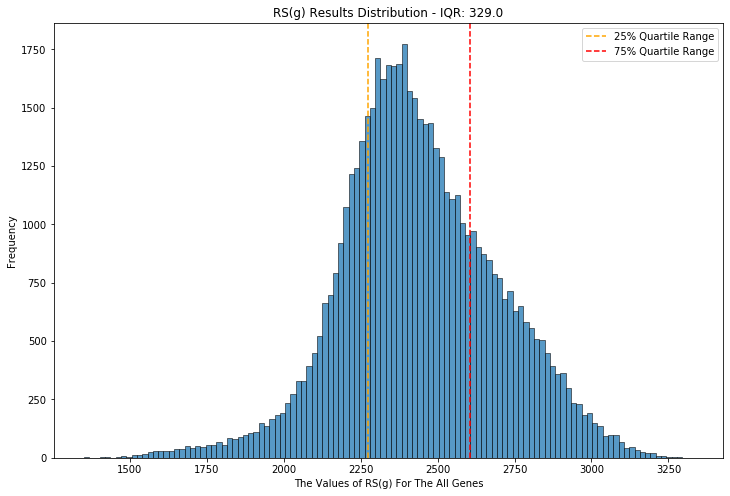

In [14]:
# compute the IQR for the distribution
genes_rs_75 = np.percentile(genes_rank_sums, 75)
genes_rs_25 = np.percentile(genes_rank_sums, 25)
genes_rs_iqr = genes_rs_75 - genes_rs_25

print(f'The IQR result: {genes_rs_iqr}')

# visualization
plt.rcParams['figure.figsize'] = (12.0, 8.0)
sns.histplot(genes_rank_sums)
plt.axvline(genes_rs_25, 0, 1, ls='--', c='orange', label='25% Quartile Range')
plt.axvline(genes_rs_75, 0, 1, ls='--', c='red', label='75% Quartile Range')
plt.xlabel('The Values of RS(g) For The All Genes')
plt.ylabel('Frequency')
plt.title(f'RS(g) Results Distribution - IQR: {genes_rs_iqr}')
plt.legend()
plt.show()

### c. Differential Expression

In this section, I computed the observed Differential Expression (DE) for each gene, using both the WRS test and the Student t-test, to determine the statistical significance in the two groups, healthy (H) against Myocardial Infraction (M).

I defined two different null models for covering the Differential Expression:
* In this part, we will define the <b>overexpressed</b> genes in M vs. H:
    * Our null hypothesis states that the differential expression in the healthy (H) group is greater (or equal) than the myocardial infraction group.
    * Alternatively, our alternative hypothesis states that the differential expression in the healthy (H) group is smaller than the myocardial infraction group.
    
    $H_0 = \mu_H \geq \mu_M$ \
    $H_A = \mu_H < \mu_M$


* In this part, we will define the <b>underexpressed</b> genes in M vs. H:
    * Our null hypothesis states that the differential expression in the healthy (H) group is smaller (or equal) than the myocardial infraction group.
    * Alternatively, our alternative hypothesis states that the differential expression in the healthy (H) group is greater than the myocardial infraction group.
    
    $H_0 = \mu_H \leq \mu_M$ \
    $H_A = \mu_H > \mu_M$

#### Results
The results will contain 4 different lists, 2 for each tests methods (WRS and t-test).
Under the null model, we will reject our null hypothesis using an alpha $(\alpha)$ threshold of 0.07.

The result can be found based on the implementation below:
* WRS:
    * The <b>overexpressed</b> list contains <b>10721</b> genes.
    * The <b>underexpressed</b> list contains <b>10618</b> genes.

* Student t-test:
    * The <b>overexpressed</b> list contains <b>8517</b> genes.
    * The <b>underexpressed</b> list contains <b>8639</b> genes.

In [40]:
# Compute the Differential Expression (DE) for each gene
# between the healthy population to the Myocardial Infraction population
cols = dataset_ref.columns[:-1]

# initial variables
wrs_over_expressed = pd.DataFrame()
wrs_under_expressed = pd.DataFrame()

t_test_over_expressed = pd.DataFrame()
t_test_under_expressed = pd.DataFrame()

for col in cols:
    h_samples = dataset_ref[dataset_ref['Class'] == 0][col]
    m_samples = dataset_ref[dataset_ref['Class'] == 1][col]

    # WRS test: over expressed: under the null model that DE_M <= DE_H (alternatively DE_M > DE_H)
    _, p_value = stats.mannwhitneyu(m_samples, h_samples, alternative='greater')
    if p_value <= 0.07:
        wrs_over_expressed[col] = pd.Series(p_value)

    # WRS test: under expressed: under the null model that DE_M >= DE_H (alternatively DE_M < DE_H)
    _, p_value = stats.mannwhitneyu(m_samples, h_samples, alternative='less')
    if p_value <= 0.07:
        wrs_under_expressed[col] = pd.Series(p_value)

    # t-test: over expressed: under the null model that DE_M <= DE_H (alternatively DE_M > DE_H)
    _, p_value = stats.ttest_ind(m_samples, h_samples, alternative='greater')
    if p_value <= 0.07:
        t_test_over_expressed[col] = pd.Series(p_value)

    # t-test: under expressed: under the null model that DE_M >= DE_H (alternatively DE_M < DE_H)
    _, p_value = stats.ttest_ind(m_samples, h_samples, alternative='less')
    if p_value <= 0.07:
        t_test_under_expressed[col] = pd.Series(p_value)

In [41]:
# using WRS
wrs_overexpressed_genes_size = wrs_over_expressed.shape[1]
wrs_underexpressed_genes_size = wrs_under_expressed.shape[1]

print('Using WRS:')
print(f'The overexpressed genes size is {wrs_overexpressed_genes_size}')
print(f'The underexpressed genes size is {wrs_underexpressed_genes_size}\n')

# using Student t-test
t_test_overexpressed_genes_size = t_test_over_expressed.shape[1]
t_test_underexpressed_genes_size = t_test_under_expressed.shape[1]

print('Using t-test:')
print(f'The overexpressed genes size is {t_test_overexpressed_genes_size}')
print(f'The underexpressed genes size is {t_test_underexpressed_genes_size}')

Using WRS:
The overexpressed genes size is 10721
The underexpressed genes size is 10618

Using t-test:
The overexpressed genes size is 8517
The underexpressed genes size is 8639


#### Results
Present samples from the results for using both WRS and Student t-test. \
For each table result, the columns represent the gene type, and the rows represent the p-value.

In [42]:
wrs_over_expressed

,117_at,1320_at,1552271_at,1552276_a_at,1552279_a_at,1552288_at,1552289_a_at,1552293_at,1552329_at,1552335_at,...,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-thr-5_s_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-M_at
0,0.000009,0.046173,0.037446,0.009437,0.042249,0.044177,0.034676,0.016542,0.001236,0.00001,...,0.039193,0.024818,0.000619,0.023235,0.030106,0.009088,0.011363,0.013867,0.058071,0.047544


In [43]:
wrs_under_expressed

,1294_at,1316_at,1405_i_at,1431_at,1552277_a_at,1552280_at,1552283_s_at,1552286_at,1552299_at,1552302_at,...,64432_at,64883_at,65438_at,65472_at,65585_at,78383_at,81811_at,91617_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_MB_at
0,0.046854,0.001049,0.001779,0.000118,0.00548,0.040698,0.003275,0.000357,0.005371,0.06055,...,0.010555,0.030115,0.000548,0.001945,0.000635,0.053354,0.003139,0.014627,0.002034,0.033616


In [44]:
t_test_over_expressed

,117_at,1320_at,1552276_a_at,1552289_a_at,1552293_at,1552329_at,1552335_at,1552337_s_at,1552349_a_at,1552355_s_at,...,89948_at,90265_at,91682_at,91684_g_at,AFFX-LysX-3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-r2-Bs-phe-3_at,AFFX-ThrX-3_at
0,0.000053,0.009004,0.014719,0.069498,0.018143,0.004454,0.000296,0.04855,0.048884,0.001807,...,0.000455,0.061341,0.000002,0.009273,0.035219,0.02725,0.035715,0.059217,0.00604,0.014331


In [45]:
t_test_under_expressed

,1316_at,1405_i_at,1431_at,1552277_a_at,1552280_at,1552283_s_at,1552286_at,1552299_at,1552310_at,1552312_a_at,...,64064_at,64408_s_at,64418_at,64883_at,65438_at,65472_at,65585_at,81811_at,91617_at,AFFX-HUMISGF3A/M97935_3_at
0,0.002408,0.016825,0.000051,0.001978,0.022217,0.001599,0.000872,0.004037,0.003449,0.043387,...,0.000002,0.044754,0.000021,0.015747,0.000939,0.008104,0.000443,0.020518,0.022389,0.025965


### d. Correlations

In this section, I generated a set of 160 genes (called D), which is the union of the 80 most significant genes each from the overexpressed and the underexpressed WRS differential expression (DE) lists.

Following the steps:
1. I computed the Kendall correlations result ($\tau$) in all the pairs within the set D (160 choose 2 numbers). Below, you can find the matrix heatmap for all the genes' pairs. I used both Kendall implementations: one from the "panad.corr" function (the Kendall method was chosen) for the correlation results, and the second from "stats.kendalltau" for the p-values (both pandas and stats return the same correlation results, thus I used pandas for efficiency purposes). 


2. Under a null model that assumes that the genes are pairwise independent, we expect that the values for the Kendall results ($\tau$) will be half (\~80x80) with positive correlations results and a half (~80x80) with negative correlations results since we generated the matrix D (160 x 160) using a union of 2 non-independet groups (overexpressed and underexpressed). \
The overexpressed genes will act/behave the same according to their expression levels, for instance, if one gene from this group will be high, we expect that an additional gene from this group will be higher as well (and the same for the underexpressed). However, if one gene from the overexpressed group will be high, we expect that a different gene from the underexpressed group will be lower (referring to a negative correlation). \
Therefore, the observed mean of the numbers within the D matrix will be around zero, since a half will be positive correlations and a half will be negative correlations.


3. According to the results below (the first heatmap visualization), we do observe a significant co-expression. In the genes from the <b>overexpressed</b> group, their expression levels act the same (considering as co-expressed, when one is higher, then the other is higher as well, and also for the lower expression levels), and the same in the <b>underexpressed</b> group. As I mentioned in question 2 when a pair contains 2 values from different groups, we observed a negative correlation. \
We can observe a significant difference in each group. The left upper (partial) and the right bottom (partial) groups represent the most co-expressions genes (positive correlation), while the left bottom group (which contains the same values as the right upper group, since the correlation matrix is symmetric) represents the negative correlation between them. 


4. I performed a False Discovery Rate (FDR) correction since we are conducting multiple comparisons. Therefore, we would like to examine the expected proportion of "discoveries" (rejected null hypotheses) that are false (incorrect rejections of the null).
Under the null model, we were required to identify how many spurious results we had from the Kendall gene's comparisons. \
The second heatmap below represents the Kendall results (based on the given alpha 0.05) after the FDR correction. We can conclude that according to the FDR correction, for the total number of pairs we observed 12,433 (= 24,866 / 2, since the matrix is symmetric) pairs out of 12720 (160 choose 2). \
\
<b>Result:</b> We observed 12,433 pairs at FDR = 0.05, using a WRS test. \
\
Regarding the co-expression pairs (inferred from the correlation of the expression levels of genes, across a set of samples), I implemented a function that counts how many co-expression pairs we have in the correlation matrix, which is conducted by using a threshold that defines a strong positive correlation (I used 0.4 as the threshold).
We can conclude that according to the FDR correction, we observed the same number of co-expressed pairs (based on the threshold parameter, the results can be found below).


5. Advantages and disadvantages of computing the co-expression for all genes in the study:
    * Advantages:
        * Computing the co-expression for all the genes in the study will contribute access to a large part of the full population, thus it helps us in obtaining quality and precise statistical results.
        * When using all the genes in the study, we should get lower p-values for rejecting our null hypothesis, i.e. our results will be more statistically significant against the genes in D.
    * Disadvantages:
        * Computing co-expression for all the genes in the study (\~50,000) will cost us a lot of computer computation (~50,000 choose 2).
        * Conducting multiple testing will present us with more spurious results and will lead us to misinterpretation based on the given data (although there are tools that we can use to detect these misinterpretations).
        * Visualization and inspection, it is challenging to achieve any conclusions from the visualization that contains enormous data points.

### Kendall Correlations

In [46]:
# Select the 80 most significant genes from the overexpressed and the underexpressed sets
overexpressed = wrs_over_expressed.sort_values(by=0, ascending=True, axis=1)
overexpressed_genes = overexpressed.columns[:80]
underexpressed = wrs_under_expressed.sort_values(by=0, ascending=True, axis=1)
underexpressed_genes = underexpressed.columns[:80]

most_significant_genes = np.concatenate((underexpressed_genes, overexpressed_genes))
D = dataset_ref[most_significant_genes]

# compute the correlation matrix and the p_values of each Kendall result respectively
D_p_values = np.zeros((D.shape[1], D.shape[1]))
D_corr = D.corr(method='kendall')

for i, gene_x in enumerate(most_significant_genes):
    for j, gene_y in enumerate(most_significant_genes):
        X = dataset_ref[gene_x]
        Y = dataset_ref[gene_y]
        r, p = stats.kendalltau(X, Y)
        D_p_values[i, j] = p

In [47]:
# compute the mean of the matrix D
D_mean = D_corr.values.mean()
print(f'The mean of the D numbers is: {D_mean}')

The mean of the D numbers is: 0.090161812318927


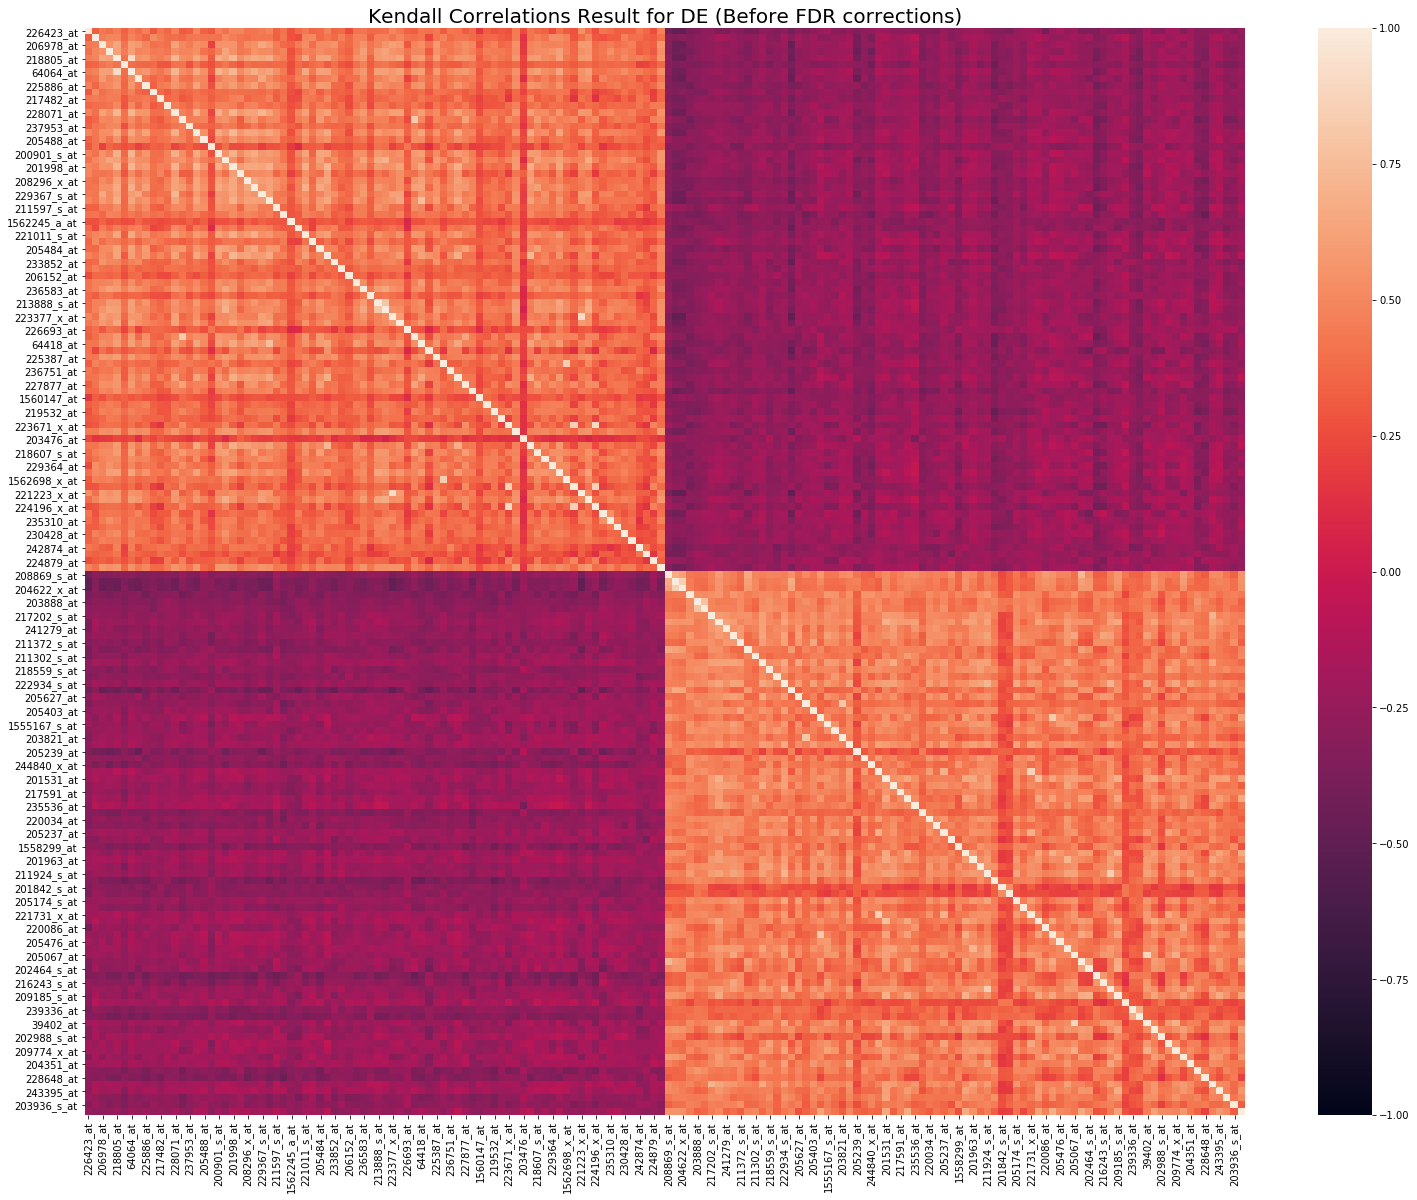

In [48]:
# visualization
plt.rcParams['figure.figsize'] = (26.0, 20.0)
sns.heatmap(D_corr, vmin=-1, vmax=1)
plt.title('Kendall Correlations Result for DE (Before FDR corrections)', fontsize=20)
plt.show()

In [49]:
######################
## helper functions ##
######################

def calc_co_expressions(corr, most_significant_genes, overexpressed_genes, underexpressed_genes, threshold=0.4):
    total_count = 0
    for i in most_significant_genes:
        for j in most_significant_genes:
            if corr[i][j] > threshold:
                total_count += 1

    over_count = 0
    for i in overexpressed_genes:
        for j in overexpressed_genes:
            if corr[i][j] > threshold:
                over_count += 1

    under_count = 0
    for i in underexpressed_genes:
        for j in underexpressed_genes:
            if corr[i][j] > threshold:
                under_count += 1

    print(f'Threshold: {threshold}')
    print(f'The number of co-expression pairs (for the overexpressed group) is: {over_count}')
    print(f'The number of co-expression pairs (for the underexpressed group) is: {under_count}')
    print(f'The sum result only from the two groups: {over_count + under_count}')
    print('------------------------------------------------------------------')
    print(f'The total co-expression pairs (without considering the related group): {total_count}')

<b>According to the function below, I present the number of the co-expression pairs, using a threshold parameter to determine a strong positive correlation.</b>

In [50]:
calc_co_expressions(D_corr, most_significant_genes, overexpressed_genes, underexpressed_genes, threshold=0.4)

Threshold: 0.4
The number of co-expression pairs (for the overexpressed group) is: 4154
The number of co-expression pairs (for the underexpressed group) is: 3314
The sum result only from the two groups: 7468
------------------------------------------------------------------
The total co-expression pairs (without considering the related group): 7468


#### An exmple of a co-expression pair of genes
Below you can observe a visualization for two different genes that are highly correlated, also known as co-expression pair.

The correlation result: 0.8511647083075655


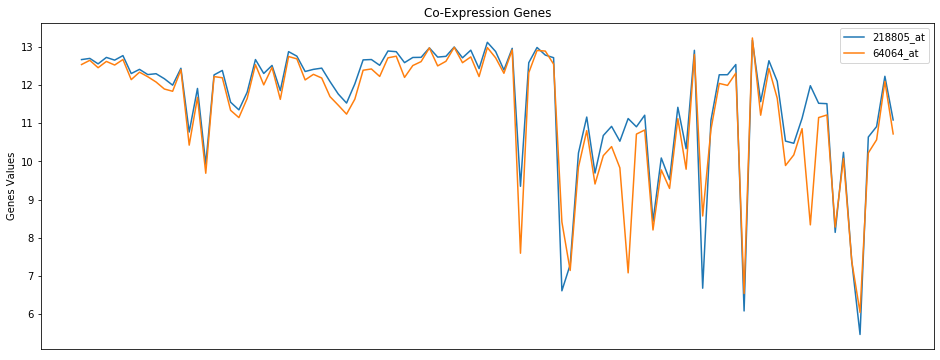

In [51]:
# correlation result
corr = D_corr['216248_s_at']['204622_x_at']
print(f'The correlation result: {corr}')
 
# refers to 2 correlated genes
X = dataset_ref['218805_at']
Y = dataset_ref['64064_at']

# visualization
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.plot(X, label='218805_at')
plt.plot(Y, label='64064_at')
plt.ylabel('Genes Values')
plt.title('Co-Expression Genes')
plt.xticks([])
plt.legend()
plt.show()

### FDR Correction

#### In the result below, I converted the correlation results which were not rejected by the FDR correction to be -1, only for visualization purposes.

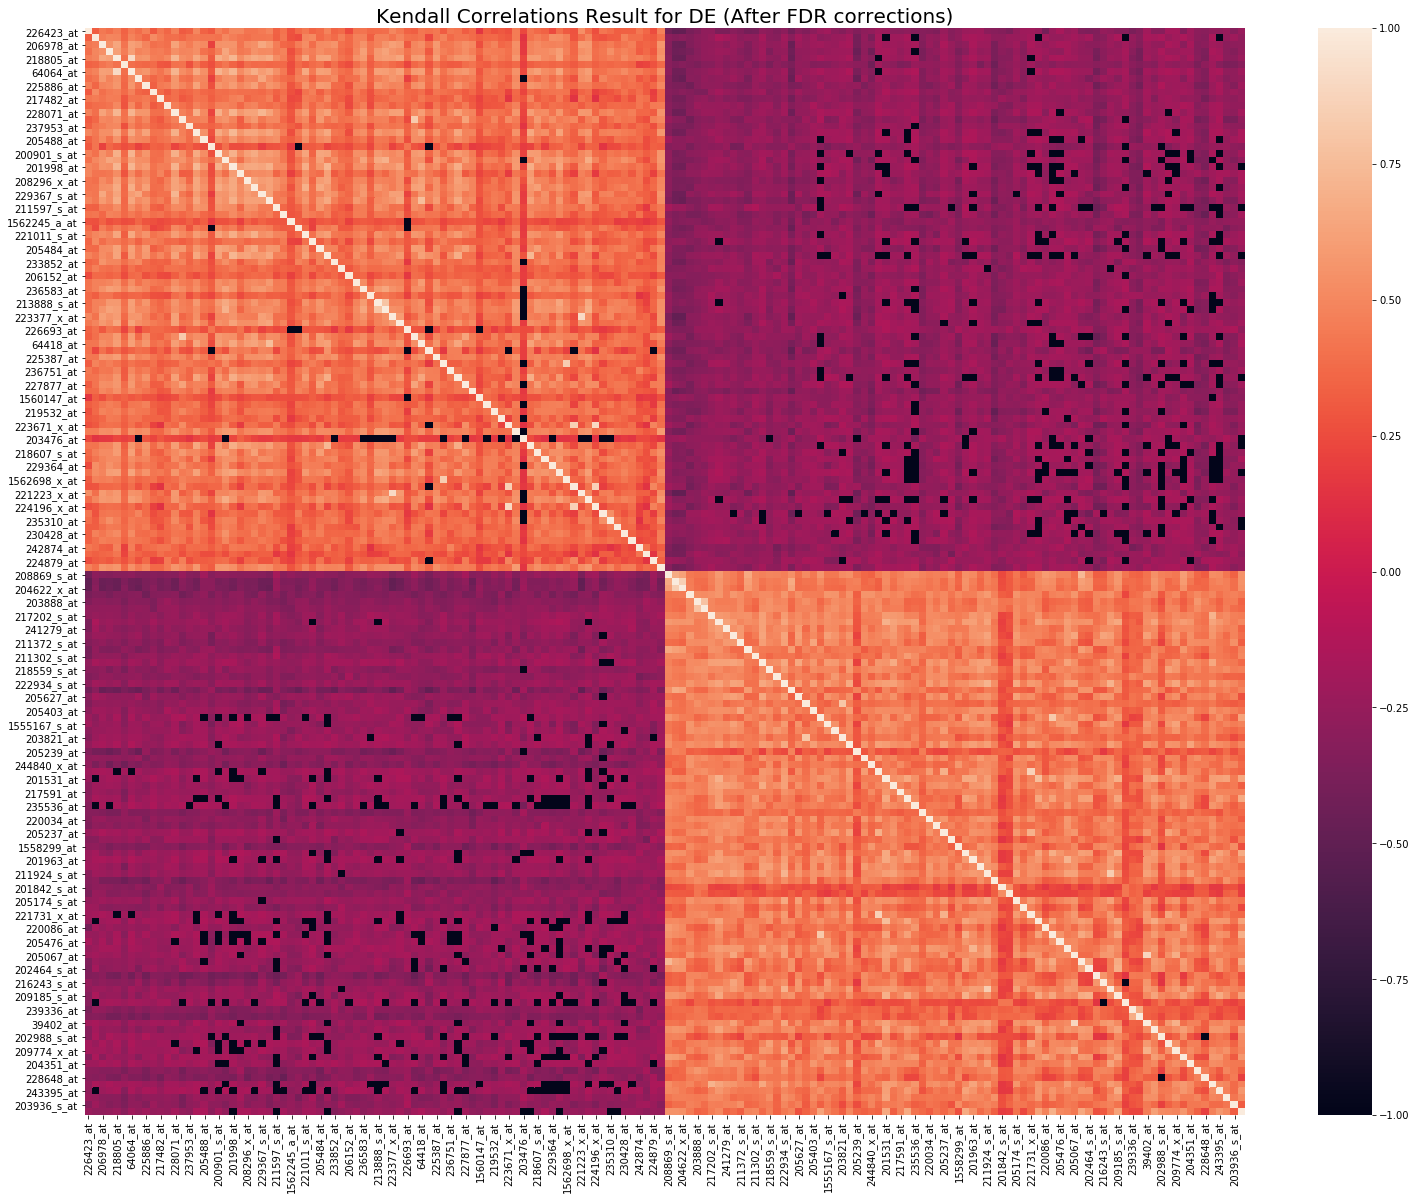

In [52]:
# compute the False Discovery Rate (FDR) among the samples in D
alpha = 0.05
r, p_values, _, _ = multitest.multipletests(D_p_values.flatten(), alpha=alpha, method='fdr_bh') # Benjamini & Hochberg
rejected = r.reshape((D.shape[1], D.shape[1]))
p_vals = p_values.reshape((D.shape[1], D.shape[1]))

D_corr_mat = D_corr.copy()
for i in range(D_corr_mat.shape[0]):
    for j in range(D_corr_mat.shape[1]):
        if not rejected[i, j]:  # (p_vals[i, j] <= 0.05):
            D_corr_mat.values[i, j] = -1

# visualization
plt.rcParams['figure.figsize'] = (26.0, 20.0)
sns.heatmap(D_corr_mat, vmin=-1, vmax=1)
plt.title('Kendall Correlations Result for DE (After FDR corrections)', fontsize=20)
plt.show()

<b>The number of the co-expression pairs after the FDR correction is <u>equal</u> to the number before the FDR correction (using a threshold of 0.4).</b> \
For a lower threshold such a 0.1, we will get different results before and after the FDR correction.

In [53]:
calc_co_expressions(D_corr_mat, most_significant_genes, overexpressed_genes, underexpressed_genes, threshold=0.4)

Threshold: 0.4
The number of co-expression pairs (for the overexpressed group) is: 4154
The number of co-expression pairs (for the underexpressed group) is: 3314
The sum result only from the two groups: 7468
------------------------------------------------------------------
The total co-expression pairs (without considering the related group): 7468


### FDR correction for all the pairs in the correlation matrix

In [54]:
# the number of the total pairs we observe in FDR=0.05
count = 0
for p in p_values:
    if p <= alpha:
        count += 1

print(f'The total number of pairs we observe in FDR={alpha} is: {count}/2 = {count/2}')

The total number of pairs we observe in FDR=0.05 is: 24866/2 = 12433.0


#### Below you can find the self implementation of the FDR computation
Return the corrected p-values (FDR matrix) and the maximal i that satisfies FDR <= alpha, where alpha is the required false discovery rate.

In [126]:
def calc_fdr(p_values, alpha, delimit=True):
    max_i = np.NINF
    sort_ind = np.argsort(p_values)
    p_values = np.take(p_values, sort_ind)

    N = len(p_values)
    idx = np.arange(1, N + 1)
    fdr = np.zeros(N + 1)

    for i, p in zip(idx, p_values):
        fdr[i] = p * N / i
        if fdr[i] <= alpha:
            if i > max_i:
                max_i = i
    
    if delimit:
        fdr[fdr > 1] = 1
    
    fdr_ = np.empty_like(fdr[1:])
    fdr_[sort_ind] = fdr[1:]

    return fdr_, max_i


fdr, max_i = calc_fdr(D_p_values.flatten(), alpha)
print(f'The total number of pairs we observe in FDR={alpha} is: {max_i}/2 = {max_i/2}')

The total number of pairs we observe in FDR=0.005 is: 24866/2 = 12433.0


### Myocardial Infraction Correlations & FDR corrections

In this section, I performed the above steps but only to the samples labeled as Myocardial Infraction (M). According to the heatmap visualization, the results for both positive and negative correlations are not in a clear deviation such as in the result on both classes (H vs. M) which affects (decreases) the number of the co-expression pairs. The values in the negative correlations were increased and the values in the positive correlations were decreased (according to the mean result it seems that there are more positive correlations now since it is positive).

Based on the results below, I received a higher mean value and lower co-expression pairs, and equal results between the before and after performing the FDR correction.

According to the heatmap correlation results, we can perhaps assume that their are genes (from both overexpressed and underexpressed) restricted only for the Myocardial Infraction samples, which do not have the same behavior.

The mean of the D numbers only for label M is: 0.14147669083724324


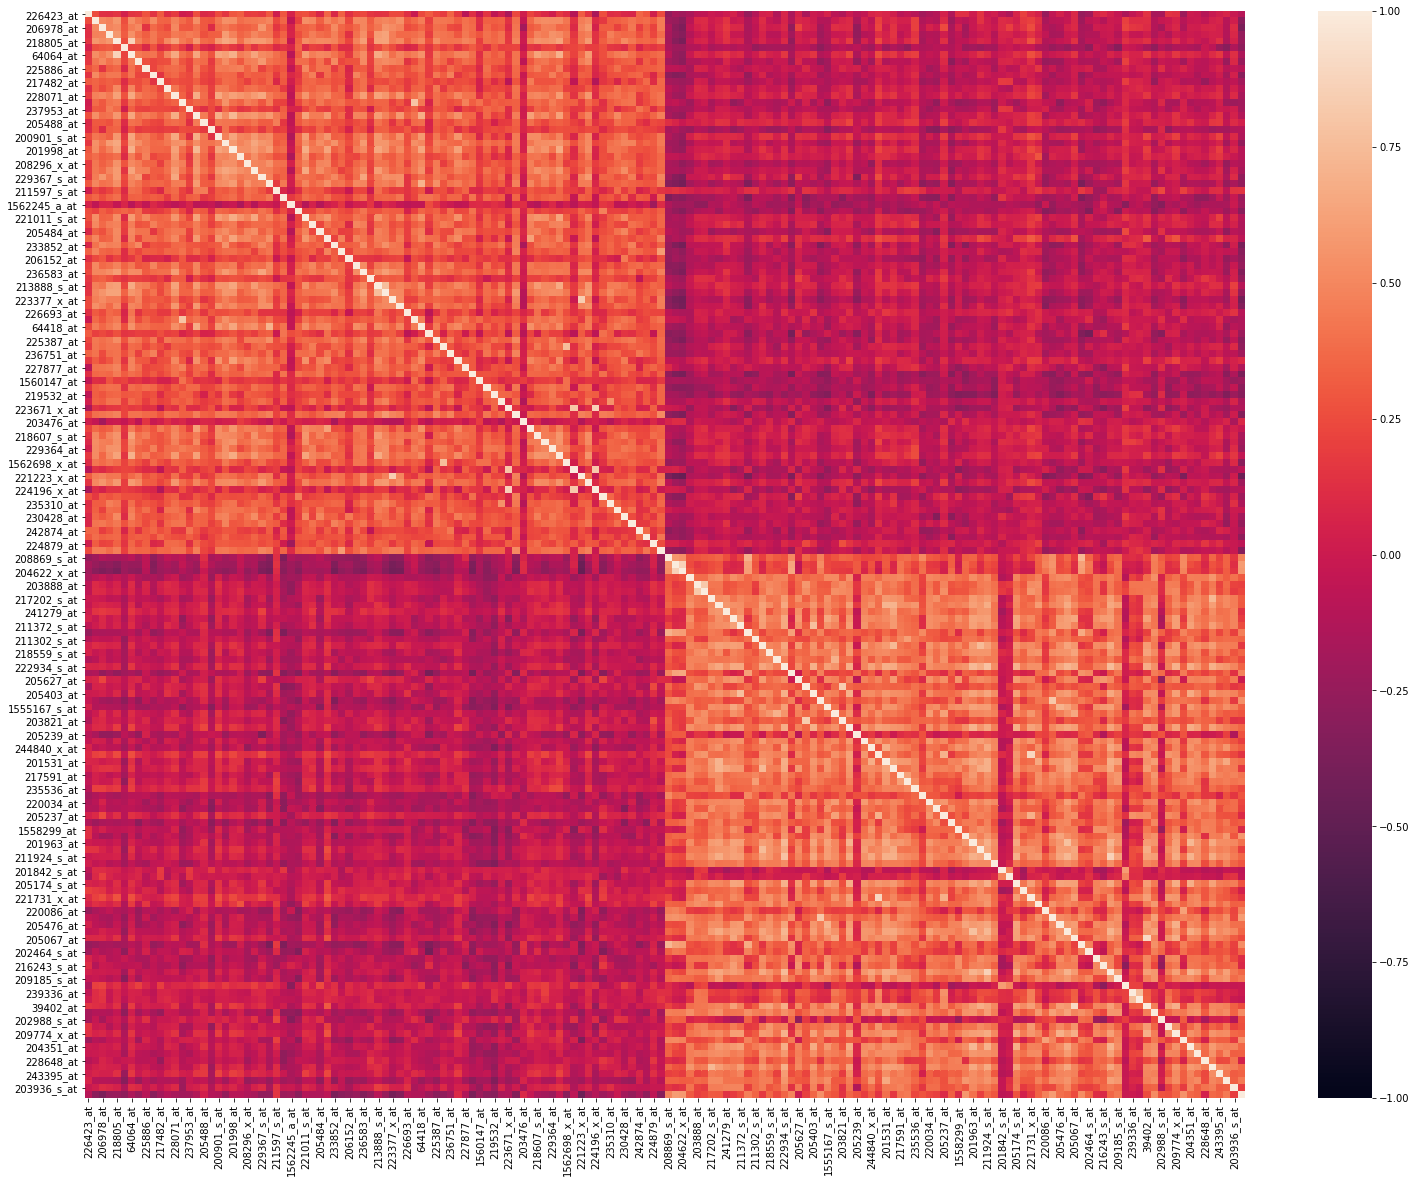

The total number of pairs we observe only for label M in FDR=0.05 is: 24866/2 = 12433.0


In [56]:
# compute the correlation and FDR correction only to samples labeled M
D_m = dataset_ref[dataset_ref['Class'] == 1][most_significant_genes]

# compute the correlation matrix and the p_values of each Kendall result respectively
D_m_p_values = np.zeros((D_m.shape[1], D_m.shape[1]))
D_m_corr = D_m.corr(method='kendall')

for i, gene_x in enumerate(most_significant_genes):
    for j, gene_y in enumerate(most_significant_genes):
        X = dataset_ref[gene_x]
        Y = dataset_ref[gene_y]
        r, p = stats.kendalltau(X, Y)
        D_m_p_values[i, j] = p

# compute the mean of the matrix D
D_m_mean = D_m_corr.values.mean()
print(f'The mean of the D numbers only for label M is: {D_m_mean}')

# visualization
plt.rcParams['figure.figsize'] = (26.0, 20.0)
sns.heatmap(D_m_corr, vmin=-1, vmax=1)
plt.show()

# self implementation for the FDR correction
fdr_m, max_i_m = calc_fdr(D_m_p_values.flatten(), alpha)
print(f'The total number of pairs we observe only for label M in FDR={alpha} is: {max_i_m}/2 = {max_i_m/2}')

<b>The number of the co-expression pairs only to samples labeled M <u>before the FDR correction</u>, using a threshold parameter to determine a strong positive correlation.</b>

In [57]:
calc_co_expressions(D_m_corr, most_significant_genes, overexpressed_genes, underexpressed_genes, threshold=0.4)

Threshold: 0.4
The number of co-expression pairs (for the overexpressed group) is: 2812
The number of co-expression pairs (for the underexpressed group) is: 1592
The sum result only from the two groups: 4404
------------------------------------------------------------------
The total co-expression pairs (without considering the related group): 4404


<b>The number of the co-expression pairs only to samples labeled M <u>after the FDR correction</u>, using a threshold parameter to determine a strong positive correlation.</b>

In [58]:
D_m_corr_fdr = D_m_corr.copy()
fdr_m = fdr_m.reshape((D_m_corr_fdr.shape[0], D_m_corr_fdr.shape[1]))

for i in range(D_corr_mat.shape[0]):
    for j in range(D_m_corr_fdr.shape[1]):
        if not (fdr_m[i, j] <= 0.05):
            D_m_corr_fdr.values[i, j] = -1

calc_co_expressions(D_m_corr_fdr, most_significant_genes, overexpressed_genes, underexpressed_genes, threshold=0.4)

Threshold: 0.4
The number of co-expression pairs (for the overexpressed group) is: 2812
The number of co-expression pairs (for the underexpressed group) is: 1592
The sum result only from the two groups: 4404
------------------------------------------------------------------
The total co-expression pairs (without considering the related group): 4404


<b>Conclusion</b>: The total co-expression pairs for label M were remain the same after the FDR correction.

### e. Plots and Conclusions of the DE and correlation analysis

In this section, I constructed the differential expression overabundance plots for the M vs. H overexpression (higher expression levels in M) using the WRS and t-test results (based on section 3.c). I performed 3 different plots for each FDR: 0.05, 0.01, and 0.005. 

<b>The results</b>
* For alpha: 0.05
    * We observed <b>2784</b> genes at FDR = 0.05, using a WRS test
    * We observed <b>2104</b> genes at FDR = 0.05, using a Student t-test
* For alpha: 0.01
    * We observed <b>1601</b> genes at FDR = 0.01, using a WRS test
    * We observed <b>1305</b> genes at FDR = 0.01, using a Student t-test
* For alpha: 0.005
    * We observed <b>1322</b> genes at FDR = 0.005, using a WRS test
    * We observed <b>1104</b> genes at FDR = 0.005, using a Student t-test
    
For the results in which the FDR is equal or greater to 1, I delimited the value to be 1 since the statistical meaning of it is that all the occurrences will be spurious. Therefore according to the overabundance plots, it can be found that all the FDR results that are equal to 1 were merged with the expected plots (to exclude the delimiter, please use "False" in the "delimit" parameter).

In [59]:
# Compute the Differential Expression (DE) for all the genes
# between the healthy population to the Myocardial Infraction population
cols_ref = dataset_ref.columns[:-1]

# initial variables
total_wrs_over_expressed = pd.DataFrame()
total_t_test_over_expressed = pd.DataFrame()

for col in cols_ref:
    h_samples = dataset_ref[dataset_ref['Class'] == 0][col]
    m_samples = dataset_ref[dataset_ref['Class'] == 1][col]

    # WRS test: over expressed: under the null model that DE_M <= DE_H (alternatively DE_M > DE_H)
    _, p_value = stats.mannwhitneyu(m_samples, h_samples, alternative='greater')
    total_wrs_over_expressed[col] = pd.Series(p_value)

    # t-test: over expressed: under the null model that DE_M <= DE_H (alternatively DE_M > DE_H)
    _, p_value = stats.ttest_ind(m_samples, h_samples, alternative='greater')
    total_t_test_over_expressed[col] = pd.Series(p_value)

In [119]:
######################
## helper functions ##
######################

def overabundance_values(fdr, p_vals):
    # sort the FDR results and the p-values
    fdr.sort()
    sort_ind = np.argsort(p_vals)
    p_i = np.take(p_vals, sort_ind)

    # set values under the null model
    N = len(p_vals)
    x = np.arange(0, 1.1, 0.1)
    y = x * N

    # compute the actual p-values occurrences
    idx = []
    for p, f in zip(p_i, fdr):
        i = p * N / f
        idx.append(i)

    return x, y, p_i, idx


def plot_DE_overabundance(wrs_over_expressed, t_test_over_expressed, alpha):
    wrs_p_vals = wrs_over_expressed.values.flatten()
    wrs_fdr, wrs_max_i = calc_fdr(wrs_p_vals, alpha, delimit=True)
    wrs_x, wrs_y, wrs_p_i, wrs_idx = overabundance_values(wrs_fdr, wrs_p_vals)
    t_test_p_vals = t_test_over_expressed.values.flatten()
    t_test_fdr, t_test_max_i = calc_fdr(t_test_p_vals, alpha, delimit=True)
    t_test_x, t_test_y, t_test_p_i, t_test_idx = overabundance_values(t_test_fdr, t_test_p_vals)

    # results
    print(f'---- alpha: {alpha} ----')
    print(f'We observed overexpressed {wrs_max_i} genes at FDR = {alpha}, using a WRS test')
    print(f'We observed overexpressed {t_test_max_i} genes at FDR = {alpha}, using a Student t-test')

    # visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.0, 6.0))

    ax1.plot(wrs_x, wrs_y, label='expected')  # the expected occurrences under the null model
    ax1.plot(wrs_p_i, wrs_idx, label='actual')  # the actual occurrences
    ax1.axvline(wrs_p_i[wrs_max_i], 0, 1, ls='--', c='r', label=f'FDR={alpha}')
    ax1.axhline(wrs_max_i, 0, 1, ls='--', c='r')
    ax1.set_title('Overexpressed genes - WRS Results')
    ax1.set_xlabel('P-Values')
    ax1.set_ylabel('Number of genes')
    ax1.legend()

    ax2.plot(t_test_x, t_test_y, label='expected')  # the expected occurrences under the null model
    ax2.plot(t_test_p_i, t_test_idx, label='actual')  # the actual occurrences
    ax2.axvline(t_test_p_i[t_test_max_i], 0, 1, ls='--', c='r', label=f'FDR={alpha}')
    ax2.axhline(t_test_max_i, 0, 1, ls='--', c='r')
    ax2.set_title('Overexpressed genes - Student t-test Results')
    ax2.set_xlabel('P-Values')
    ax2.set_ylabel('Number of genes')
    ax2.legend()

    f.suptitle(f'DE overabundance plots - alpha:{alpha}')
    plt.show()

In [120]:
print(f'The number of genes before the FDR correction (WRS): {wrs_over_expressed.shape[1]}')
print(f'The number of genes before the FDR correction (Student t-test): {t_test_over_expressed.shape[1]}')

The number of genes before the FDR correction (WRS): 10721
The number of genes before the FDR correction (Student t-test): 8517


---- alpha: 0.05 ----
We observed overexpressed 2784 genes at FDR = 0.05, using a WRS test
We observed overexpressed 2104 genes at FDR = 0.05, using a Student t-test


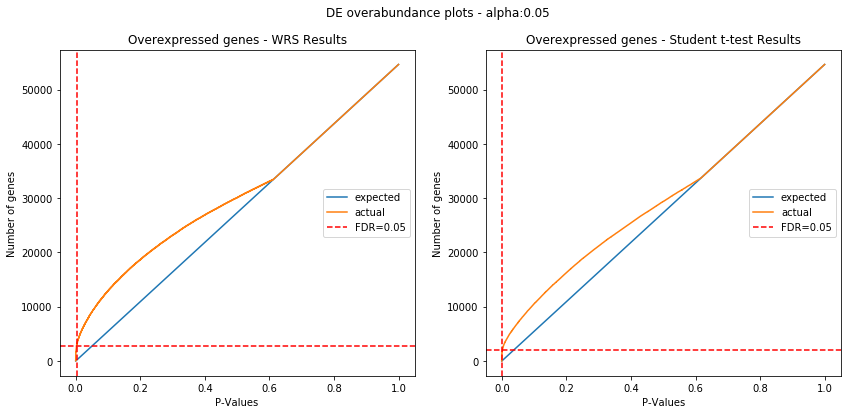

---- alpha: 0.01 ----
We observed overexpressed 1601 genes at FDR = 0.01, using a WRS test
We observed overexpressed 1305 genes at FDR = 0.01, using a Student t-test


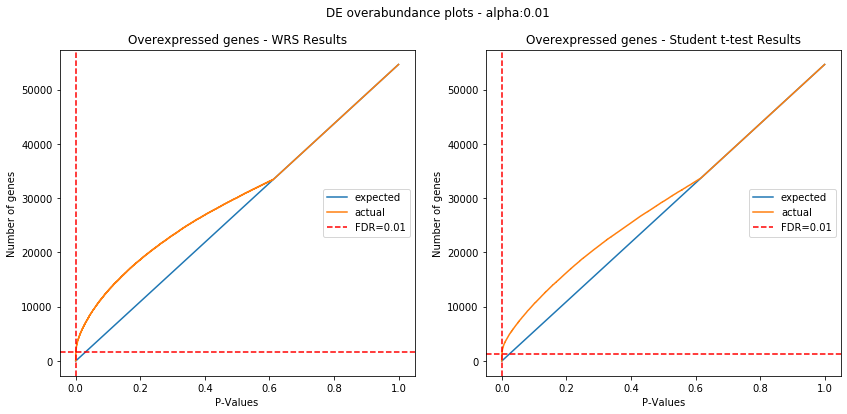

---- alpha: 0.005 ----
We observed overexpressed 1322 genes at FDR = 0.005, using a WRS test
We observed overexpressed 1104 genes at FDR = 0.005, using a Student t-test


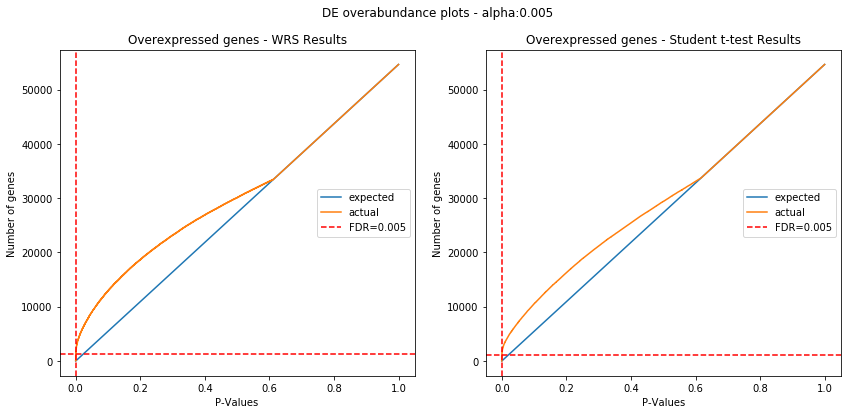

In [121]:
alphas = [0.05, 0.01, 0.005]
for alpha in alphas:
    plot_DE_overabundance(total_wrs_over_expressed, total_t_test_over_expressed, alpha)

#### Graphical Representation Of The Differentially Expressed Genes
I selected 3 differentially expressed genes, from D (which was defined in 3.d), and produced a graphical representation of their expression patterns that demonstrates the observed DE.

The DE genes (using the WRS test results):
* From the <b>overexpressed</b> list:
    * 216248_s_at
    * 203888_at
* From the <b>underexpressed</b> list:
    * 206978_at

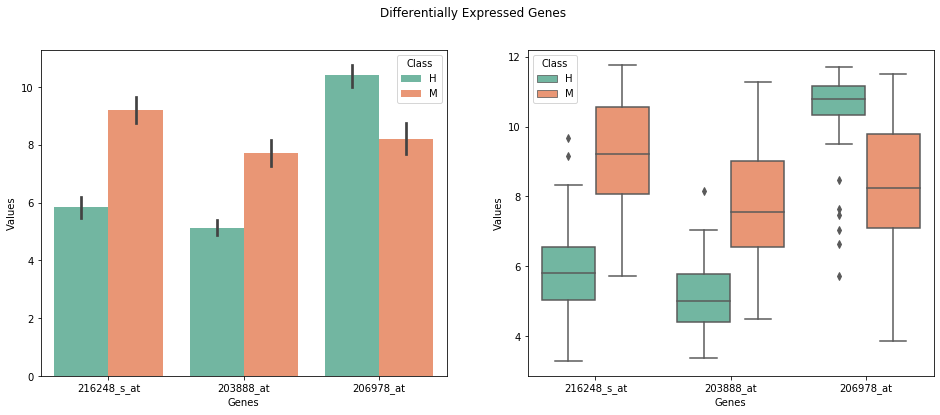

In [94]:
# set the Dataframe for these genes
df_de_genes = dataset_ref[['216248_s_at', '203888_at', '206978_at', 'Class']]

# fix the table structure for the visualization
df_de_genes = df_de_genes.melt(id_vars=['Class'], var_name='Genes', value_name='Values')

# visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.0, 6.0))
df_de_genes['Class'] = df_de_genes['Class'].replace({0: 'H', 1: 'M'})
sns.barplot(x='Genes', y='Values', hue='Class', data=df_de_genes, palette="Set2", ax=ax1)
sns.boxplot(x='Genes', y='Values', hue='Class', data=df_de_genes, palette="Set2", ax=ax2)
f.suptitle('Differentially Expressed Genes')
plt.show()

#### Heatmap Representation
In this section, I drew a heatmap representation of the expression values of the genes in D, across the entire cohort (all samples). I ordered the samples between the two classes Healthy (H) and Myocardial Infraction (M), and I ordered by the genes' expressions (overexpressed and underexpressed according to the Myocardial Infraction label).

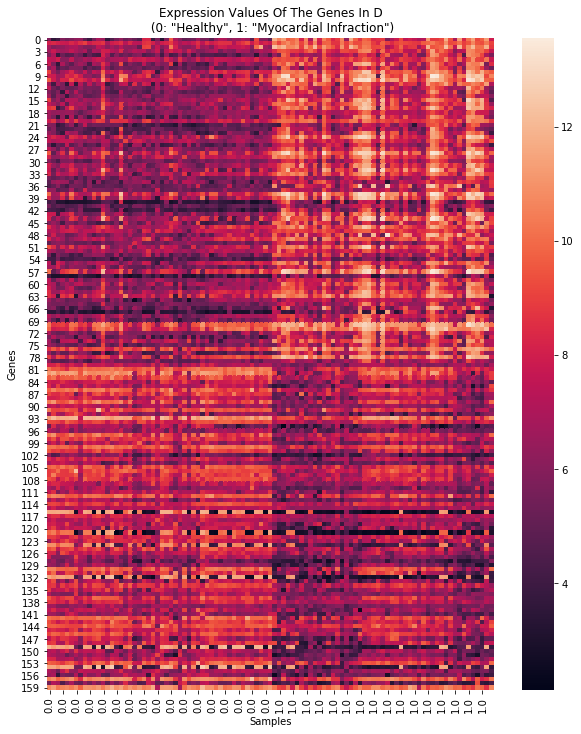

In [125]:
# order by the genes and the samples
overexpressed_ = t_test_over_expressed.sort_values(by=0, ascending=True, axis=1)
overexpressed_genes_ = overexpressed_.columns[:80]
underexpressed_ = t_test_under_expressed.sort_values(by=0, ascending=True, axis=1)
underexpressed_genes_ = underexpressed_.columns[:80]

most_significant_genes = np.concatenate((overexpressed_genes_, underexpressed_genes_))
most_significant_genes = np.concatenate((['Class'], most_significant_genes))
D_heatmap = dataset_ref[most_significant_genes]
D_heatmap = D_heatmap.sort_values(by=['Class'], ascending=True)
D_heatmap = D_heatmap.T

new_columns_names = D_heatmap.iloc[0]
D_heatmap = D_heatmap[1:]
D_heatmap.columns = new_columns_names
D_heatmap = D_heatmap.reset_index()
D_heatmap = D_heatmap.rename(columns={'index': 'Genes'}, inplace=False)
D_heatmap = D_heatmap.rename_axis(None, axis=1)
D_heatmap.drop('Genes', inplace=True, axis=1)

# visualization
plt.rcParams['figure.figsize'] = (10.0, 12.0)
sns.heatmap(D_heatmap)
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.title('Expression Values Of The Genes In D\n (0: "Healthy", 1: "Myocardial Infraction")')
plt.show()